In [1]:
%matplotlib inline

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import gc
import os

# from sklearn import svm, decomposition
from preprocess import remove_high_freq, whitening, from_cifar_to_np, from_submit_to_np
from plot import imshow
from util import trainNN, cal_accuracy, cal_class_accuracy, get_submit_result, export_to_file, print_accracy
from models import *

use_pca = False
use_forieum = False
resume = True
export_csv = True

csv_name = 'res_resnet_auto_lr.csv'
checkpoint_name = 'resnet_ckpt.pth'
accuracy_plot_name = 'resnet_acc.png'

BATCH_SIZE = 1500
LR = 1e-4
EPOCHS = 300
momentum = 0.9
weight_decay = 7e-3

best_accuracy = 0.0
epoch = 0

In [3]:
print('==> Preparing data..')
transform_train = transforms.Compose(
    [
         transforms.RandomCrop(32, padding=4),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
         transforms.RandomCrop(32, padding=4),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]) 

transform_test = transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]) 


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)
submitdata = np.load("./test/y_test.npy").astype(np.uint8)

submit_images = [ transform_test(img) for img in submitdata]

submitloader = torch.utils.data.DataLoader(submit_images, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainX, trainY = from_cifar_to_np(trainloader)
if not use_forieum:
    trainX = np.reshape(trainX, (50000, 3072))
print("Shape of training data: ")
print(trainX.shape)
print(trainY.shape)

Shape of training data: 
(50000, 3072)
(50000,)


In [5]:
testX, testY = from_cifar_to_np(testloader)
if not use_forieum:
    testX = np.reshape(testX, (10000, 3072))

print("Shape of testing data: ")
print(testX.shape)
print(testY.shape)

Shape of testing data: 
(10000, 3072)
(10000,)


In [6]:
submitX = from_submit_to_np(submitloader)
if not use_forieum:
    submitX = np.reshape(submitX, (12000, 3072))

print("Shape of submitting data: ")    
print(submitX.shape)

Shape of submitting data: 
(12000, 3072)


In [7]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


torch.Size([128, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  cat  frog  ship plane   dog plane  deer plane


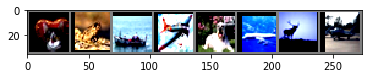

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
 
# print(images)
print(images.size())

# show images in a batch, which contains 8 images
imshow(torchvision.utils.make_grid(images[0:8]))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [11]:
print('==> Building model..')
# net = SeventySevenNet()
net = ResNet18()
# net = LargeNet()
# net = VGG('VGG19')
# net = WeakerNet21()
# net = PreActResNet18()
net = net.to(device)
criterion = nn.CrossEntropyLoss()


if resume:
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/' + checkpoint_name)
    net.load_state_dict(checkpoint['net'])
    best_accuracy = checkpoint['acc']
    epoch = checkpoint['epoch']
    print(best_accuracy)
    print(epoch)

==> Building model..
==> Resuming from checkpoint..
0.9314
260


In [10]:
# def adjust_learning_rate(optimizer, epoch):
#     """Sets the learning rate to the initial LR divided by 5 at 50th, 100th and 140th epochs"""
#     lr_tmp = LR * ((0.2 ** int(epoch >= 50)) * (0.2 ** int(epoch >= 100))* (0.2 ** int(epoch >= 140)))

#     for param_group in optimizer.param_groups:
#         param_group["lr"] = lr_tmp


In [ ]:
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=momentum, weight_decay=weight_decay)
train_acc_plt = []
test_acc_plt = []

for i in range(epoch, EPOCHS): 
    time_start = time.time()
#     adjust_learning_rate(optimizer, i+1)
    
    trainNN(net, trainloader, optimizer, criterion,  1)
    
    train_accuracy = cal_accuracy(net, trainloader)
    test_accuracy = cal_accuracy(net, testloader)
    train_acc_plt.append(train_accuracy)
    test_acc_plt.append(test_accuracy)
    
    time_end = (time.time() - time_start)
    
    if test_accuracy > best_accuracy: 
        print('Saving...')
        state = {
            'net': net.state_dict(),
            'acc': test_accuracy,
            'epoch': i+1,
            'train_his': train_acc_plt,
            'test_his': test_acc_plt
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/'+checkpoint_name)
        best_accuracy = test_accuracy
        
    print(f'EPOCH: {i}/{EPOCHS} \t',
          f'Time: {round(time_end)} sec \t', 
          "Train Accuracy:", round(100 * train_accuracy,6), '% \t'
          "Test Accuracy:", round(100 * test_accuracy,6), '% \t'
          "Best Accuracy:", round(100 * best_accuracy,6), '%'
         )
    

Training starts
[1,   100] double loss: 0.0000873
[1,   200] double loss: 0.0000963
[1,   300] double loss: 0.0000937
Saving...
EPOCH: 260/300 	 Time: 166 sec 	 Train Accuracy: 99.96 % 	Test Accuracy: 93.2 % 	Best Accuracy: 93.2 %
Training starts
[1,   100] double loss: 0.0000932
[1,   200] double loss: 0.0000948
[1,   300] double loss: 0.0000983
EPOCH: 261/300 	 Time: 162 sec 	 Train Accuracy: 99.956 % 	Test Accuracy: 93.15 % 	Best Accuracy: 93.2 %
Training starts
[1,   100] double loss: 0.0000972
[1,   200] double loss: 0.0000979
[1,   300] double loss: 0.0001050
EPOCH: 262/300 	 Time: 161 sec 	 Train Accuracy: 99.966 % 	Test Accuracy: 93.08 % 	Best Accuracy: 93.2 %
Training starts
[1,   100] double loss: 0.0001094
[1,   200] double loss: 0.0001065
[1,   300] double loss: 0.0001074
EPOCH: 263/300 	 Time: 161 sec 	 Train Accuracy: 99.972 % 	Test Accuracy: 93.08 % 	Best Accuracy: 93.2 %
Training starts
[1,   100] double loss: 0.0001096
[1,   200] double loss: 0.0001156
[1,   300] doubl

In [22]:
for param_group in optimizer.param_groups:
    print(param_group["lr"])
    param_group["weight_decay"] = 5e-3
    print(param_group["weight_decay"])

for i in range(epoch, EPOCHS + 10): 
    time_start = time.time()
    adjust_learning_rate(optimizer, i+1)
    
    trainNN(net, trainloader, optimizer, criterion,  1)
    
    train_accuracy = cal_accuracy(net, trainloader)
    test_accuracy = cal_accuracy(net, testloader)
    train_acc_plt.append(train_accuracy)
    test_acc_plt.append(test_accuracy)
    
    time_end = (time.time() - time_start)
    
    if test_accuracy > best_accuracy: 
        print('Saving...')
        state = {
            'net': net.state_dict(),
            'acc': test_accuracy,
            'epoch': i+1,
            'train_his': train_acc_plt,
            'test_his': test_acc_plt
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/'+checkpoint_name)
        best_accuracy = test_accuracy
        
    print(f'EPOCH: {i}/{EPOCHS} \t',
          f'Time: {round(time_end)} sec \t', 
          "Train Accuracy:", round(100 * train_accuracy,6), '% \t'
          "Test Accuracy:", round(100 * test_accuracy,6), '% \t'
          "Best Accuracy:", round(100 * best_accuracy,6), '%'
         )

0.0008000000000000003
0.005
Training starts
[1,   100] double loss: 0.0000153
[1,   200] double loss: 0.0000151
[1,   300] double loss: 0.0000161
EPOCH: 157/170 	 Time: 158 sec 	 Train Accuracy: 99.986 % 	Test Accuracy: 92.08 % 	Best Accuracy: 92.17 %
Training starts
[1,   100] double loss: 0.0000195
[1,   200] double loss: 0.0000210
[1,   300] double loss: 0.0000203
EPOCH: 158/170 	 Time: 159 sec 	 Train Accuracy: 99.998 % 	Test Accuracy: 92.05 % 	Best Accuracy: 92.17 %
Training starts
[1,   100] double loss: 0.0000202
[1,   200] double loss: 0.0000212
[1,   300] double loss: 0.0000282
EPOCH: 159/170 	 Time: 160 sec 	 Train Accuracy: 99.996 % 	Test Accuracy: 92.0 % 	Best Accuracy: 92.17 %
Training starts
[1,   100] double loss: 0.0000241
[1,   200] double loss: 0.0000271
[1,   300] double loss: 0.0000273
EPOCH: 160/170 	 Time: 162 sec 	 Train Accuracy: 99.994 % 	Test Accuracy: 91.98 % 	Best Accuracy: 92.17 %
Training starts
[1,   100] double loss: 0.0000266
[1,   200] double loss: 0.0

In [12]:
params = list(net.parameters())
print(len(params))

54


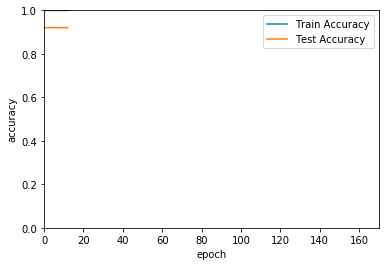

In [13]:
plt.plot(train_acc_plt, label='Train Accuracy')
plt.plot(test_acc_plt, label='Test Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.axis([0, EPOCHS, 0, 1])
plt.legend()
plt.savefig('./plots/'+accuracy_plot_name)
plt.show()

In [14]:
cal_class_accuracy(net, testloader)

Accuracy of plane : 95 %
Accuracy of   car : 100 %
Accuracy of  bird : 86 %
Accuracy of   cat : 79 %
Accuracy of  deer : 89 %
Accuracy of   dog : 87 %
Accuracy of  frog : 90 %
Accuracy of horse : 96 %
Accuracy of  ship : 97 %
Accuracy of truck : 93 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


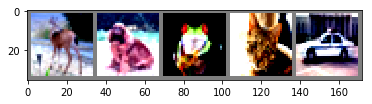

In [15]:
images = submit_images[2100:2105]
imshow(torchvision.utils.make_grid(images))

(1500, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


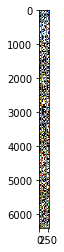

In [16]:
dataiter = iter(submitloader)
images = dataiter.next()
print(np.array(images).shape)
imshow(torchvision.utils.make_grid(images))

In [17]:
gc.collect()

1990

In [18]:
# res_labels = get_submit_result(net, submitloader)
res_per = []
with torch.no_grad():
    for i, data in enumerate(submitloader, 0):
        inputs = data.to(device)
        # forward + backward + optimize
        outputs = net(inputs)
        for o in outputs:
            res_per.append(o)
res_labels = [int(torch.max(t,0)[1]) for t in res_per]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane plane truck plane truck plane  ship  ship  ship plane plane plane plane plane  ship plane plane  deer plane plane  ship plane plane plane plane plane plane plane plane truck


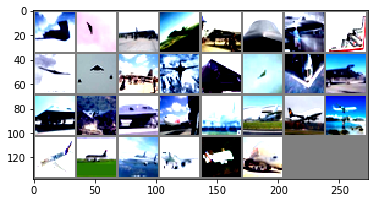

In [19]:
images = submit_images[0:30]
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[res_labels[j]] for j in range(0, 30)))

In [20]:
if export_csv:
    export_to_file(csv_name, res_labels)